# Plotting Script for Plotting B/G color MEI bias 

In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True
dj.config['schema_name'] = "nnfabrik_color_mei"
schema = dj.schema("nnfabrik_color_mei")

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *

import nnfabrik
from collections import namedtuple
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlutils.measures import corr

from mlutils.data.datasets import StaticImageSet, FileTreeDataset
from nndichromacy.tables.from_nnfabrik import TrainedModel, DataInfo
from dataport.bcm.static import PreprocessedMouseData
from nnvision.utility.measures import get_explainable_var

from nndichromacy.tables.from_mei import MEI, TrainedEnsembleModel, MEISelector, MEIMethod, MEISeed

Connecting kwilleke@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306


### Select a dataset and method hash. If there is more than one ensemble for that dataset, chose an ensemble_hash instead.

In [20]:
mei_key = dict(method_hash='e203277aa2540dd9f907344ed5babb21', dataset_hash='68db788514e66723ffb230875164d577', seed=1000)

In [21]:
from nndichromacy.tables.scores import CorrelationToAverge
mei_paths = (MEI() * CorrelationToAverge.Units() & mei_key).fetch("mei", order_by='unit_avg_correlation DESC')
MEIs = np.stack([torch.load(path).detach().cpu().numpy().squeeze() for path in mei_paths])


In [50]:
mei_norm = np.empty((MEIs.shape[0], 2))
for i, mei in enumerate(MEIs):
    mei_norm[i, 0] = (np.linalg.norm(mei[0,::]))
    mei_norm[i, 1] = (np.linalg.norm(mei[1,::]))

# Unnormalized Plot

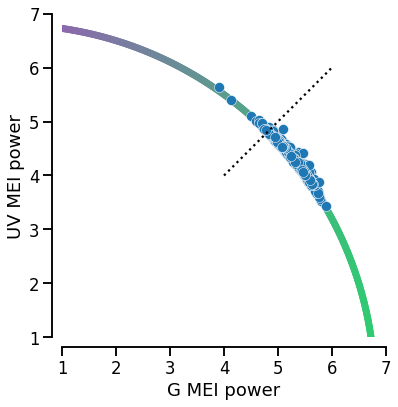

In [63]:
# subplots dataset_keys
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.set_context('talk', font_scale=1)
cmap = sns.blend_palette(['#9b59b6', '#2ecc71',], as_cmap=True)

l_lim = mei_norm.min()
u_lim = mei_norm.max()
x = np.linspace(0, np.pi/2, 500)
ax.scatter(np.cos(x)*6.8, np.sin(x)*6.8, c=np.cos(x), cmap=cmap, s=30, vmin=0, vmax=1)
ax.scatter(mei_norm[:,0], mei_norm[:,1], edgecolors='w', s=100, linewidths=.5)
plt.plot([4, 6], [4, 6], 'k:')
ax.set_aspect('equal', 'box')
ax.set_xlim(1,7)
ax.set_ylim(1,7)
ax.set_xlabel("G MEI power")
ax.set_ylabel("UV MEI power")
sns.despine(trim=True, offset=10)
plt.tight_layout()
#plt.savefig("Color_Bias_Checkerboard.png", dpi=100, bbox_inches='tight')

# Normalized Plot

In [55]:
mei_norm_zscore = mei_norm / np.linalg.norm(mei_norm, axis=1).mean()

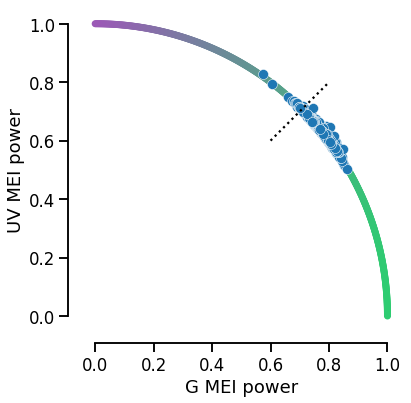

In [62]:
# subplots dataset_keys
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.set_context('talk', font_scale=1)
cmap = sns.blend_palette(['#9b59b6', '#2ecc71',], as_cmap=True)

l_lim = mei_norm_zscore.min()
u_lim = mei_norm_zscore.max()
x = np.linspace(0, np.pi/2, 500)
ax.scatter(np.cos(x), np.sin(x), c=np.cos(x), cmap=cmap, s=30, vmin=0, vmax=1)
ax.scatter(mei_norm_zscore[:,0], mei_norm_zscore[:,1], edgecolors='w', s=100, linewidths=.5)
ax.plot([.6, .8], [.6, .8], 'k:')
ax.set_aspect('equal', 'box')
ax.set_xlabel("G MEI power")
ax.set_ylabel("UV MEI power")
sns.despine(trim=True, offset=10)
plt.tight_layout()
#plt.savefig("Color_Bias_Checkerboard.png", dpi=100, bbox_inches='tight')

# Cleanup: Remove the fetched mei files

In [64]:
for i, path in enumerate(mei_paths):
    if os.path.exists(os.path.join(os.getcwd(), path)):
        os.remove(os.path.join(os.getcwd(), path))